# Back-Testing for Algorithmic Trading Strategies

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yahoofinancials as yf
from yahoo_fin.stock_info import *
import requests_html
import requests
import ftplib
import ta


<b>Let's get the historical time series data of the stock by specifying the start and end dates<b>

In [28]:
df = pd.read_csv('stock_data.csv')

In [29]:
df.head()

,Unnamed: 0,date,high,low,open,close,volume,adjclose,formatted_date
0,0,1609745400,18.610001,18.299999,18.350000,18.360001,36331500,18.098007,2021-01-04
1,1,1609831800,18.510000,18.180000,18.320000,18.280001,33769846,18.019148,2021-01-05
2,2,1609918200,18.950001,18.430000,18.500000,18.709999,73963507,18.443010,2021-01-06
3,3,1610004600,19.170000,18.790001,18.799999,18.950001,66513392,18.679588,2021-01-07
4,4,1610091000,19.150000,18.900000,19.059999,18.980000,32197137,18.709156,2021-01-08


In [30]:
df.drop(['date','Unnamed: 0'], axis=1, inplace=True)

In [31]:
df.index = pd.to_datetime(df['formatted_date'])
df.drop('formatted_date', axis=1, inplace=True)

<b>Let's change the name of the adjclose variable to 'Price'.<b>

In [32]:
df.rename(columns={'adjclose': 'price'}, inplace=True)

<b>Let's change the price change to 'return' (daily return) and assign the percentage change in the price to 'return_pct'.

In [33]:
df["return"] = df["price"].diff()
df["return_pct"] = df["price"].pct_change()

<b>Time Series Graph of Price and Return

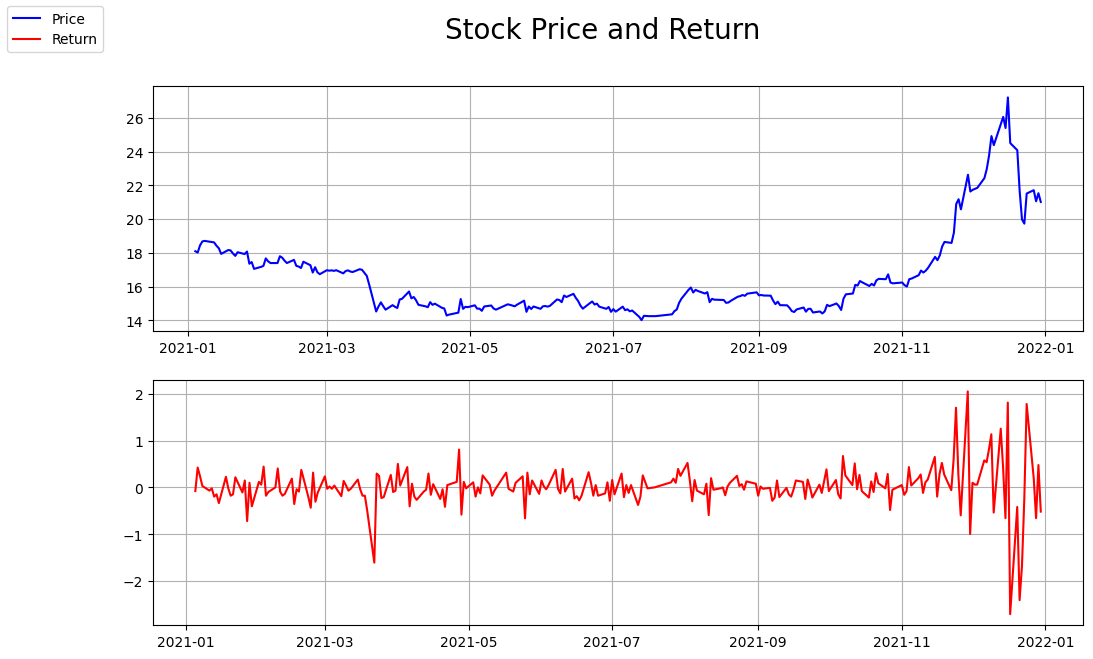

In [34]:
f, axarr = plt.subplots(2,sharex=False,figsize=(12,7))
f.suptitle('Stock Price and Return', fontsize=20)
axarr[0].plot(df['price'], color='blue')
axarr[0].grid(True)
axarr[1].plot(df['return'], color='red')
axarr[1].grid(True)
f.legend(['Price', 'Return'], loc='upper left')
plt.show()